## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

### **Tarea 2: Algoritmos de entrenamiento y aproximación de esperanzas condicionales**

**Profesores: Claudio Muñoz y Joaquín Fontbona**

**Auxiliares: Javier Maass y Diego Olguín**

**Nombres integrantes: Allen Arroyo & Isidora Miranda**



**Instrucciones:**

- **Fecha de entrega:** **31 de mayo de 2024, a las 23:59.**

- **Importante:** Si trabaja desde el link de Google Colab debe hacer un copia en su Drive antes de trabajar, de lo contrario se podrían no guardar sus códigos.

- Debe entregar un Jupyter Notebook (archivo .ipynb) con sus código en Python. Le pueden ser de mucha utilidad los códigos vistos en la actividad práctica.

- Sus códigos deben estar comentados y ordenados. Además, en formato texto debe colocar todas sus conclusiones y resultados pedidos que deban ser redactados.

- En todos los ejercicios se le pide hacer al menos un gráfico. Los gráficos que realicen deben ser claros, con títulos y nombres en los ejes, junto con leyendas si es que corresponde.

#### **Ejercicio 1: Algoritmo Adam**

En el presente [artículo](https://arxiv.org/abs/1412.6980) se introduce el algoritmo de optimización estocástica Adam (por Adaptative Moment Estimation), el objetivo de este ejercicio es implementar dicho algoritmo y utilizarlo para entrenar redes neuronales, para ello se explorarán todos los detalles de implementación de una red neuronal, con ciertas simplificaciones.

Utilizaremos Adam para entrenar una red neuronal de 1 capa oculta de $\mathbb{R}$ en $\mathbb{R}$, de ancho $N$, con su realización dada por

$$ \Phi_\theta (x) = W_2 \cdot \sigma (W_1 \cdot x + b_1) + b_2 $$

Consideraremos $\sigma(x) = \text{tanh}(x)$ y $\theta = (W_1, b_1, W_2, b_2)$, $W_1 \in \mathbb{R}^{N \times 1}$, $b_1 \in \mathbb{R}^{N}$, $W_2 \in \mathbb{R}^{1 \times N}$, $b_2 \in \mathbb{R}$. En este caso codificaremos, los parámetros del sistema en un vector de $\mathbb{R}^{3N + 1}$ dado por

$$ \theta = (W_1, b_1, W_2, b_2)^T $$

Esto no es lo que hacen las librerías de aprendizaje profundo en la realidad, pero en este caso permite simplificar mucho los manejos de estructuras de datos utilizadas.

Para lo que sigue utilizaremos la librería ``autograd`` (instalada ya en Google Colab) que facilitará implementar la diferenciación automática (utilizada en las librerías más importantes de *deep learning*) para calcular facilmente el gradiente de la función de pérdida. Esta librería sobrescribe la librería ``numpy`` por lo que ahora utilizaremos esa librería con el sobrenombre ``np`` como si fuese la librería original.

In [ ]:
# Numpy de autograd
import autograd.numpy as np

# Función de gradiente mediante diferenciación automática
from autograd import grad

# Para graficar
import matplotlib.pyplot as plt

# Generar dataframes
import pandas as pd

Buscaremos ajustar la red neuronal a datos *sampleados* desde una función $\text{cos}(x)$ con cierto ruido gaussiano. Generemos los datos antes de empezar el ejercicio.

In [ ]:
# Función a aproximar, es la funcion coseno, recibe un valor de input
def f_true(x):
    return np.cos(x)

In [ ]:
f_true(2)

-0.4161468365471424

In [ ]:
xdim = 1   # Dimensión de input
Ndata = 20 # Cantidad de datos a samplear
ydim = 1   # Dimensión de output

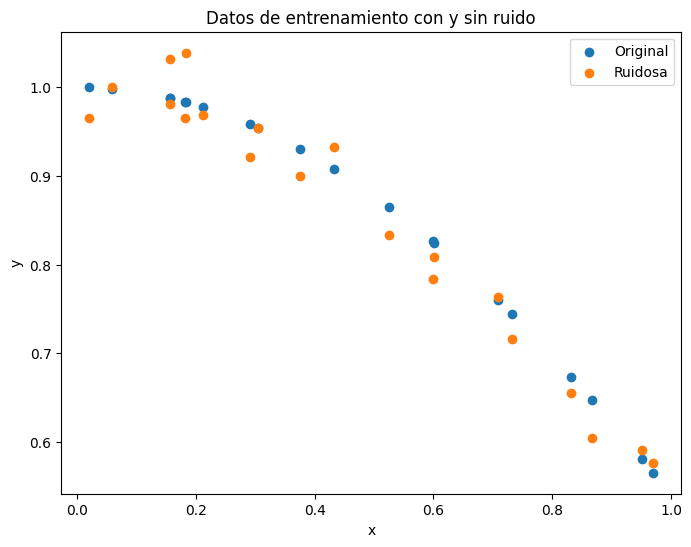

In [ ]:
# Datos aleatorios
#Esto es una matriz de 1X20

np.random.seed(42)
x_train = np.random.random((xdim, Ndata))

# Sampleo de datos
desv = 3e-2

#Aca np.random.rand(*x_train.shape) es un array de números aleatorios con distribución normal (media 0 y desviación estándar 1) con la misma forma que x_train.
#mulplicado por la desviacion de datos que establecimos
y_train = f_true(x_train) + desv*np.random.randn(*x_train.shape)

plt.figure(figsize=(8,6))
plt.scatter(x_train.flatten(), f_true(x_train).flatten(), label="Original")
plt.scatter(x_train.flatten(), y_train.flatten(), label="Ruidosa")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos de entrenamiento con y sin ruido")
plt.legend()
plt.show()

#### **Ejercicio 1.1: Creación de una red neuronal de 1 capa oculta**

Cree una función en Python ``net(params, x)`` que dados los parámetros codificados en un arreglo de ``numpy`` tal como se mostró arriba y un conjunto de datos $x \in \mathbb{R}^{1 \times N_{data}}$ calcule el output de la red. Pruebe su función con parámetros inicializados aleatoriamente desde una uniforme estándar y el arreglo ``x_train`` creado antes.

In [ ]:
def net(params, x):

    # Desempaquetamos los parámetros del vector params
    #Aca W_1 es de dimension Ndata x 1, ya que x_train es de dimension 1 x Ndata

    #Consideremos los primeros Ndata elementos de params y luego los transformamos
    # a una matriz de Ndata x 1

    W_1 = params[0:Ndata].reshape(Ndata, 1)

    #Luego consideramos los siguientes Ndata elementos de params
    b_1 = params[Ndata:2*Ndata]  # ojo que acá debe ser Ndata y no Ndata+1

    #Acá consideramos los ultimos Ndata elementos de params
    #Donde tenemos que W_2 tiene dimension 1 x Ndata ya que x_1 tendra
    #dimension Ndata x Ndata y queremos que el output tenga dimension 1xNdata

    W_2 = params[2*Ndata:3*Ndata].reshape(1, Ndata) #  ojo que acá debe ser 2*Ndata y no 2*Ndata+1
    b_2 = params[3*Ndata]                           #  b_2 es de una dimensión.

    # Calculamos la salida de la capa oculta usando tanh como funcion de activacion.
    # b_1 antes lo extraimos como un arreglo de Ndata valores, pero nosotros
    # necesitamos que sea de dimensión Ndata x 1, es decir un vector de Ndata valores.
    # Notar que np.dot(W_1, x) está bien definido pues W_1 es de dimensión Ndata x 1
    # y x es de dimensión 1xNdata

    hidden = np.tanh(np.dot(W_1, x) + b_1[:, None]) # hidden tendrá dimensión Ndata x 1

    # Calculamos la salida de la red neuronal
    output = np.dot(W_2, hidden) + b_2 # recordar que W_2 es de dim  1 x Ndata

    return output


1. Generamos params inicializada aleatoriamente desde una uniforme estándar en $\mathbb{R}^{3 \cdot Ndata + 1}$

In [ ]:
np.random.seed(42)
params = np.random.randn(3*Ndata + 1)  # uniforme estándar
params

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
       -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124,
        0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
       -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016,
        0.32408397, -0.38508228, -0.676922  ,  0.61167629,  1.03099952,
        0.93128012, -0.83921752, -0.30921238,  0.33126343,  0.97554513,
       -0.47917424])

In [ ]:
# Probamos la función con parámetros inicializados aleatoriamente desde una uniforme estándar params y el arreglo x_train anterior.

Ndata = 20 # Cantidad de datos a samplear
net(params,x_train)

array([[-0.11076562, -2.04969181, -1.38871748, -0.92397369,  0.61817602,
         0.6182499 ,  0.90479611, -1.81224514, -0.93280494, -1.30800019,
         1.00755696, -2.10019709, -1.71087559,  0.44132945,  0.53821193,
         0.53325831,  0.13536297, -0.65574801, -0.31720967,  0.17987977]])

1. Grafico de los resultados de la red para $params$ e $x_{train}$, claramente la red no aproxima a la función coseno en [0,1].

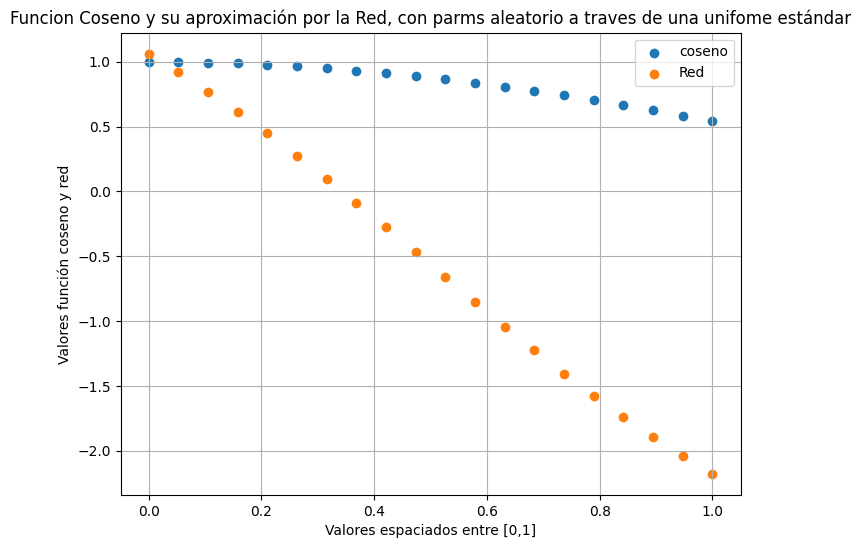

In [ ]:
# # Recordar que nuestro arreglo es net(params, x_train)[0] y no net(params,x_train)

np.random.seed(42)
x_prueba_1 = np.linspace(0, 1, 20).reshape(1, 20)

plt.figure(figsize=(8,6))
plt.scatter(x_prueba_1[0], f_true(x_prueba_1)[0], label="coseno")
plt.scatter(x_prueba_1[0], net(params, x_prueba_1)[0], label="Red")
plt.xlabel("Valores espaciados entre [0,1]")
plt.ylabel("Valores función coseno y red")
plt.title("Funcion Coseno y su aproximación por la Red, con parms aleatorio a traves de una unifome estándar")
plt.legend()
plt.grid(True)
plt.show()

Notamos que los valores de la función son totalmente random, lo cual es consistente.

In [ ]:
# Notar que es posible calcular net de un input x de 1x1

prueba = np.array([[0.84428144]])
net(params,prueba)

array([[-1.74686638]])

#### **Ejercicio 1.2: Creación de la función de pérdida por *batches***

La naturaleza estocástica del algoritmo proviene de que no se le entregan todos los datos de entrenamiento, sino que una muestra diferente en cada iteración de entrenamiento, dichas muestras las denotaremos *batches*. Implemente una función en Python ``loss(params)`` que dados unos parámetros ``params`` $\theta$ haga lo siguiente:

* Obtenga un subarreglo de tamaño $(1, N_{batches})$ de ``x_train`` de manera aleatoria y sin sustitución, digamos ``x_batch``.
* Obtenga el ``y_batch`` correspondiente.
* Calcule la pérdida cuadrática en este *batch*:

$$ L(\theta) = \sum_{i=1}^{N_{batch}} (y_i - \Phi_\theta (x_i))^2 $$

Y donde se entiende que hay una reindexación para sumar sobre todo el *batch*.

In [ ]:
# Considerando que  params, x_train, y_train deben ser definidos antes.

def loss(params,Nbatches):

    # La dimensión de x_train (en este caso el len) debe ser mayor o igual que Nbatches
    #if 1 <= Nbatches <= x_train.shape[1]  and type(Nbatches) is int :

      # Generar una permutación aleatoria de los índices de x_train
      indices_permutados = np.random.permutation(x_train.shape[1])

      # Inicializar la pérdida total(perdida cuadrada del batch)
      total_loss = 0

      # Realizamos la suma :
      # Calculamos el error para cada y_batch[i] e phi_tetha(x_batch[i])
      for k in range(Nbatches): # vamos a sumar Nbatches valores
          # Extraemos el indice nuevo en indices_permutados
          indice_permutado = indices_permutados[k]
          # Seleccionamos un x_train[k] datos de entrenamiento
          x_batch_k = x_train[0][indice_permutado].reshape(1,1)
          # Seleccionamos un y_train[k] en correspondecia del x_train[k]
          y_batch_k = y_train[0][indice_permutado].reshape(1,1)

          # Calcular la salida de la red neuronal para el batch[k] actual
          predictions_batch_k = net(params, x_batch_k)

          # Calcular la pérdida cuadrática para el batch[k] actual
          loss_batch = np.sum((y_batch_k - predictions_batch_k)**2)
          # la suma y_batch_k - predictions_batch_k es bien definida.

          # Agregar la pérdida del batch[k] actual a la pérdida total
          total_loss += loss_batch
    #else  :
       #print("Elección de Nbatches fuera de rango")

      return total_loss

In [ ]:
# Ejemplo:

loss(params,Nbatches=5),loss(params,Nbatches=10),loss(params,Nbatches=20)

(13.498775725134005, 16.326200855898033, 47.2986758840312)

#### **Ejercicio 1.3: Cálculo del gradiente vía autodiferenciación y comparación con diferencias finitas**

Con la función ``grad`` de ``autograd`` calcule el gradiente de la función de pérdida antes creada, con tamaño de *batch* igual a ``Ndata``, es decir, la función de pérdida se vuelve determinista en este caso (ya que le pasamos todos los datos al tomar los batches sin sustitución. Compare en norma este gradiente con el cálculado mediante por diferencias finitas centradas

$$ \frac{\partial L}{ \partial \theta_j} (\theta) \approx \frac{L(\theta + \varepsilon e_j) - L(\theta - \varepsilon e_j)}{2 \varepsilon} $$

Para $\varepsilon \in \{ 10, 1, 0.1, 0.01 \}$, evaluado los gradientes en los mismo parámetros utilizados en la parte anterior.

1. Aplicamos grad a la función anteriro $loss$ con $Nbacthes = Nadata = 20$.  

In [ ]:
# Recordemos que nuestro params es :
params

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
       -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124,
        0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
       -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016,
        0.32408397, -0.38508228, -0.676922  ,  0.61167629,  1.03099952,
        0.93128012, -0.83921752, -0.30921238,  0.33126343,  0.97554513,
       -0.47917424])

In [ ]:
# Suponiendo que tenemos params, x_train, y_train, Ndata guardados y tomamos Nbatches=20

gradiente_L = grad(loss)(params,Nbatches=20)
gradiente_L

array([ -2.41640141,  -5.17457543,   2.87210309,   8.91215875,
        30.73657664,  24.05337212,  14.11524487, -16.12190304,
        -5.2081875 ,  57.77733863,  -4.93691335,   2.37500444,
        22.07485457,  -0.75638222, -25.6014814 ,  -4.41229749,
        20.59166358,   1.25771673,  -0.81364419, -16.83215392,
        -4.01258634,  -7.85324418,   4.56281179,  12.14909755,
        47.55256012,  36.26406145,  20.30861999, -27.02759715,
        -8.38452242,  87.27899307,  -7.93960275,   3.32472781,
        33.43803611,  -1.80725508, -40.82716544,  -7.40314352,
        33.32191514,   1.79724286,  -1.4869326 , -29.62136833,
       -47.85193212,  15.55028618, -22.85310423,  17.48640341,
        30.54147186,   2.25033018,   4.07960831, -35.24966831,
        36.33981036,  -3.43046083,  36.27388832, -46.12298066,
        -7.37760879,  49.12385267,  14.02987452,  46.49156642,
        20.91663278,  47.65449578,  48.34160215,  29.65004987,
       -50.65121473])

2. Para el cálculado "mediante por diferencias finitas centradas"

Notar que en $L(\theta + ɛ)$ sumar $ɛ$ a los $ \theta = (W_1, b_1, W_2, b_2)^T $, es simplemente sumar en cada posición al arreglo entregado, pues $\theta$ fue codificado en un vector de $\mathbb{R}^{3N + 1}$dimensiones.

In [ ]:
def gradiente_dif_finitas_centras(params,epsilon,Nbatches) :
  dim = len(params)

  gradiente = np.zeros(dim, dtype=float)
  for k in range(dim) :
      params_new_plus, params_new_minus = np.copy(params), np.copy(params)

      params_new_plus[k] = params_new_plus[k] + epsilon
      params_new_minus[k] = params_new_minus[k] - epsilon

      numerador = loss(params_new_plus,Nbatches) - loss(params_new_minus,Nbatches)
      denominador = 2*epsilon
      gradiente[k] = gradiente[k] + numerador/denominador
  return gradiente

In [ ]:
# Ejemplo para epsilon = 10.

gradiente_dif_finitas_centras(params,10,Nbatches=20)

array([ -5.07496538,  -0.83312124,   0.56495547,   1.62381598,
        11.70510362,   3.64240085,   2.47394744,  -7.71381582,
        -1.45029697,   8.98729461,  -1.38268383,   1.47473993,
         3.2333471 ,  -1.92346904,  -4.94676329,  -2.18169664,
         4.91517291,   1.71979824,  -1.31000103,  -3.48112952,
        -5.77330004,  -0.83501365,   0.56773396,   1.72459405,
        12.48023436,   3.63828227,   2.62565841,  -8.04353046,
        -1.42619291,   9.4597348 ,  -1.36228442,   1.40197407,
         3.2519873 ,  -1.70222128,  -5.37194848,  -1.60731828,
         4.89267971,   1.92859124,  -1.26845699,  -3.55196549,
       -47.85193212,  15.55028618, -22.85310423,  17.48640341,
        30.54147186,   2.25033018,   4.07960831, -35.24966831,
        36.33981036,  -3.43046083,  36.27388832, -46.12298066,
        -7.37760879,  49.12385267,  14.02987452,  46.49156642,
        20.91663278,  47.65449578,  48.34160215,  29.65004987,
       -50.65121473])

In [ ]:
# Para todos los epsilons del enunciado :

Epsilons = [10,1,0.1,0.01]
m,n = len(Epsilons), len(params)

# Guardamos los 4 calculos de gradiente
gradientes_difFC = np.zeros((m, n), dtype=float)
for k in range(m) :
    epsilon = Epsilons[k]
    grad = gradiente_dif_finitas_centras(params,epsilon,Nbatches=20)
    gradientes_difFC[k] = grad

In [ ]:
column_names = [f'Gradiente para epsilon={epsilon}' for epsilon in Epsilons]
df = pd.DataFrame(gradientes_difFC.T, columns=column_names) # trasponermos el arreglo gradientes_difFC para que sean columnas vizualmente
df

,Gradiente para epsilon=10,Gradiente para epsilon=1,Gradiente para epsilon=0.1,Gradiente para epsilon=0.01
0,-5.074965,-3.306044,-2.424646,-2.416484
1,-0.833121,-4.505466,-5.166788,-5.174497
2,0.564955,2.719970,2.871140,2.872094
3,1.623816,7.638070,8.895880,8.911995
4,11.705104,34.620187,30.793897,30.737152
...,...,...,...,...
56,20.916633,20.916633,20.916633,20.916633
57,47.654496,47.654496,47.654496,47.654496
58,48.341602,48.341602,48.341602,48.341602
59,29.650050,29.650050,29.650050,29.650050


3. Diferencias con respecto a los dos metodos para determinar gradiente de función $L(\theta)$.

Ahora se calcularan las diferencias en norma con respecto al valor entregado por la función grad de Autograd y los cuatro gradientes mediante "diferencias finitas centradas".

El arreglo Diferencias tendrá las diferencias en norma entre gradiente_L y los 4 gradientes_difFC[k] con $k \in \{0,1,2,3,4\}$.

Por ejemlo se quiere obtener la diferencia en norma entre gradiente_L y  gradientes_difFC con $ɛ = 10$ se debe extraer el subarreglo Diferencias[0], mientras que para $ɛ = 1$ es el subarreglo Diferencias[1].

In [ ]:
def diferencia(arreglo1,arreglo2) :
   dif = np.abs(arreglo1 - arreglo2) # lo hace por coordenadas para np.arrays
   return dif

In [ ]:
# Ejemplo :

diferencia(gradiente_L ,  gradientes_difFC[0])

array([2.65856396e+00, 4.34145419e+00, 2.30714762e+00, 7.28834277e+00,
       1.90314730e+01, 2.04109713e+01, 1.16412974e+01, 8.40808722e+00,
       3.75789053e+00, 4.87900440e+01, 3.55422953e+00, 9.00264509e-01,
       1.88415075e+01, 1.16708682e+00, 2.06547181e+01, 2.23060085e+00,
       1.56764907e+01, 4.62081506e-01, 4.96356841e-01, 1.33510244e+01,
       1.76071370e+00, 7.01823053e+00, 3.99507783e+00, 1.04245035e+01,
       3.50723258e+01, 3.26257792e+01, 1.76829616e+01, 1.89840667e+01,
       6.95832952e+00, 7.78192583e+01, 6.57731833e+00, 1.92275374e+00,
       3.01860488e+01, 1.05033800e-01, 3.54552170e+01, 5.79582524e+00,
       2.84292354e+01, 1.31348384e-01, 2.18475609e-01, 2.60694028e+01,
       4.97379915e-14, 0.00000000e+00, 3.55271368e-15, 1.77635684e-14,
       1.06581410e-14, 0.00000000e+00, 6.21724894e-15, 7.10542736e-15,
       2.84217094e-14, 1.77635684e-15, 0.00000000e+00, 0.00000000e+00,
       2.66453526e-15, 2.13162821e-14, 5.32907052e-15, 0.00000000e+00,
      

In [ ]:
# Guardamos las 4 diferencias en un arreglo para luego graficar.

n = len(gradientes_difFC) # El len de este arreglo es 4, tenemos 4 gradientes_difFC para los respectivos 4 epsilons
Diferencias = np.zeros(n, dtype=object) # Para ir guardando los 4 arreglos
for i in range(n) : # recorremos 0,1,2,3
    Diferencias[i] = diferencia(gradiente_L ,gradientes_difFC[i])
Diferencias

array([array([2.65856396e+00, 4.34145419e+00, 2.30714762e+00, 7.28834277e+00,
              1.90314730e+01, 2.04109713e+01, 1.16412974e+01, 8.40808722e+00,
              3.75789053e+00, 4.87900440e+01, 3.55422953e+00, 9.00264509e-01,
              1.88415075e+01, 1.16708682e+00, 2.06547181e+01, 2.23060085e+00,
              1.56764907e+01, 4.62081506e-01, 4.96356841e-01, 1.33510244e+01,
              1.76071370e+00, 7.01823053e+00, 3.99507783e+00, 1.04245035e+01,
              3.50723258e+01, 3.26257792e+01, 1.76829616e+01, 1.89840667e+01,
              6.95832952e+00, 7.78192583e+01, 6.57731833e+00, 1.92275374e+00,
              3.01860488e+01, 1.05033800e-01, 3.54552170e+01, 5.79582524e+00,
              2.84292354e+01, 1.31348384e-01, 2.18475609e-01, 2.60694028e+01,
              4.97379915e-14, 0.00000000e+00, 3.55271368e-15, 1.77635684e-14,
              1.06581410e-14, 0.00000000e+00, 6.21724894e-15, 7.10542736e-15,
              2.84217094e-14, 1.77635684e-15, 0.00000000e+00, 0.

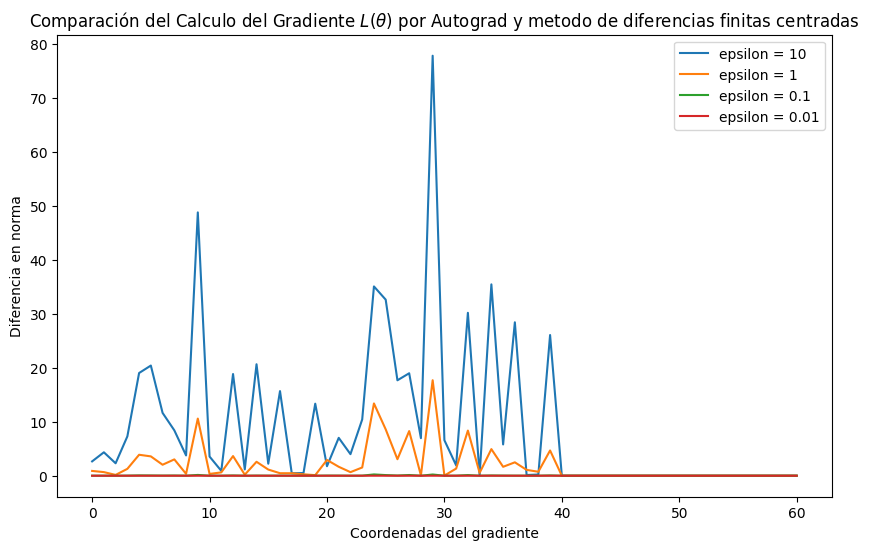

In [ ]:
# Tenemos el arreglo Diferencias de 4 subarreglos

# Tenemos los valores para epsilon
Epsilons = [10,1,0.1,0.01]

plt.figure(figsize=(10, 6))

# Itera sobre cada arreglo de diferencias y su correspondiente epsilon
for k, epsilon in enumerate(Epsilons):
    plt.plot(Diferencias[k], label=f'epsilon = {epsilon}')

plt.title('Comparación del Calculo del Gradiente $L(\\theta)$ por Autograd y metodo de diferencias finitas centradas')
plt.xlabel('Coordenadas del gradiente')
plt.ylabel('Diferencia en norma')

plt.legend()
plt.show()

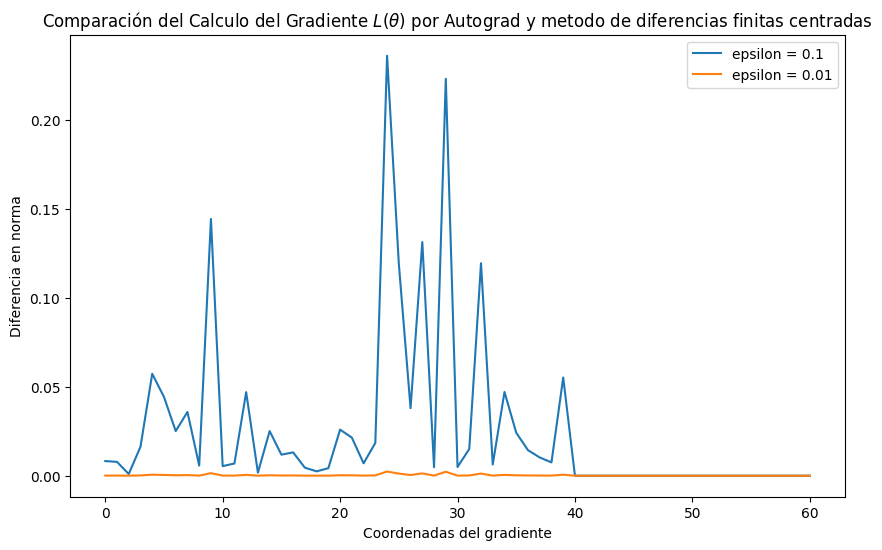

In [ ]:
# Ploteamos los 2 mejores epsilon, el 0.1 y 0.01 :

plt.figure(figsize=(10, 6))

# Itera sobre cada arreglo de diferencias y su correspondiente epsilon
plt.plot(Diferencias[2], label=f'epsilon = {0.1}')
plt.plot(Diferencias[3], label=f'epsilon = {0.01}')

plt.title('Comparación del Calculo del Gradiente $L(\\theta)$ por Autograd y metodo de diferencias finitas centradas')
plt.xlabel('Coordenadas del gradiente')
plt.ylabel('Diferencia en norma')

plt.legend()
plt.show()

#### **Ejercicio 1.4: Implementación de Adam**

Vuelva a calcular el gradiente de la función de pérdida, pero ahora utilizando un tamaño de batch de $5$ (ahora sí se vuelve aleatoria la función de pérdida). Utilice 10000 iteraciones para el algoritmo y los mismos parámetros $\alpha, \beta_1, \beta_2, \varepsilon$ del artículo original. Grafique la evolución de la función de pérdida a través de las iteraciones en escala log-log (escala logarítmica en ambos ejes) y el resultado de la red en contraste con los datos y la función sin ruido evaluada en los puntos de entrenamiento.

Los parametros del paper son
$$  \alpha=0.001, \hspace{3mm} \beta_1=0.9 ,  \hspace{3mm}  \beta_2=0.999, \hspace{3mm}  ɛ=10^{-8}$$

In [ ]:
def adam_optimize(params,alpha=0.001, beta1=0.9 , beta2=0.999, epsilon=10**-8,  iter=10_001,  Nbatches=5):
  params  = np.copy(params)
  perdida = np.zeros(iter)

  m = np.zeros_like(params) # (Initialize 1st moment vector m0)
  v = np.zeros_like(params) # (Initialize 2nd moment vector v0)
  t = 1                    # (Initialize timestep)

  while t in range(iter):   # realizamos iter iteraciones

    # calculamos el gradiente de la funcion de perdida para el theta actual "params"
    perdida[t-1] = loss(params,Nbatches) #Guardamos el valor de la función de perdida para cada iteración

    # grad = gradiente_dif_finitas_centras(params,epsilon,Nbatches)
    grad_l = grad(loss)(params,Nbatches)
    # se refien los m,v
    m = beta1*m + (1-beta1)*grad_l
    v = beta2*v + (1-beta2)*np.square(grad_l)

    # Evitar división por cero usando np.where
    mCAP = m / (1 - beta1 ** t)    # (bias-corrected first moment estimate)
    vCAP = v / (1 - beta2 ** t)    # (bias-corrected second raw moment estimate)

    # Actualización de los parámetros
    params = params - alpha * mCAP / (np.sqrt(vCAP) + epsilon)  # (Update parameters)

    t += 1
  return params,perdida

In [ ]:
valores_adam = adam_optimize(params,alpha=0.001, beta1=0.9 , beta2=0.999, epsilon=10**-8,  iter=10_000,  Nbatches=5)
# Nota si se vuelve a corre a veces python tiene un error al definir grad_l = grad(loss)(params,Nbatches), si es así,
# simplemente cambiar el nombre por cualquier otro.

In [ ]:
# La perdida asociada es :

valores_adam[1]

array([9.38661651e+00, 1.19243841e+01, 9.86034389e+00, ...,
       2.52059065e-03, 1.63370301e-03, 0.00000000e+00])

In [ ]:
# los nuevos parametros son :

valores_adam[0]

array([ 0.6220744 ,  0.02003443,  0.55122988,  1.34892116, -0.38404699,
       -0.41607164,  1.41790758,  0.8687341 , -0.31518175,  0.37127786,
       -0.30927939, -0.73022637,  0.07658469, -1.7791261 , -1.5909732 ,
       -0.41814079, -1.10759677,  0.13989619, -0.79853157, -1.35179449,
        1.42170424, -0.15833274,  0.00524983, -1.56135262, -0.56826844,
        0.05806343, -1.25839054,  0.32325109, -0.58115971, -0.36129292,
       -0.58080839,  1.67820424, -0.07430886, -1.22564371,  0.83364036,
       -1.24493454,  0.25364962, -2.05294662, -1.4030854 ,  0.14465391,
        0.80845059,  0.09088872,  0.03448513, -0.14178673, -1.57003314,
       -0.98335753, -0.1603708 ,  1.17086237,  0.25133378, -1.49276855,
        0.23206392, -0.33647139, -0.51171574,  0.53399444,  0.75592529,
        0.85785871, -1.02608555, -0.37185116,  0.25855147,  0.80459606,
       -0.41488879])

1. Grafico de la evolución de la función de pérdida a través de las iteraciones en escala log-log (escala logarítmica en ambos ejes).

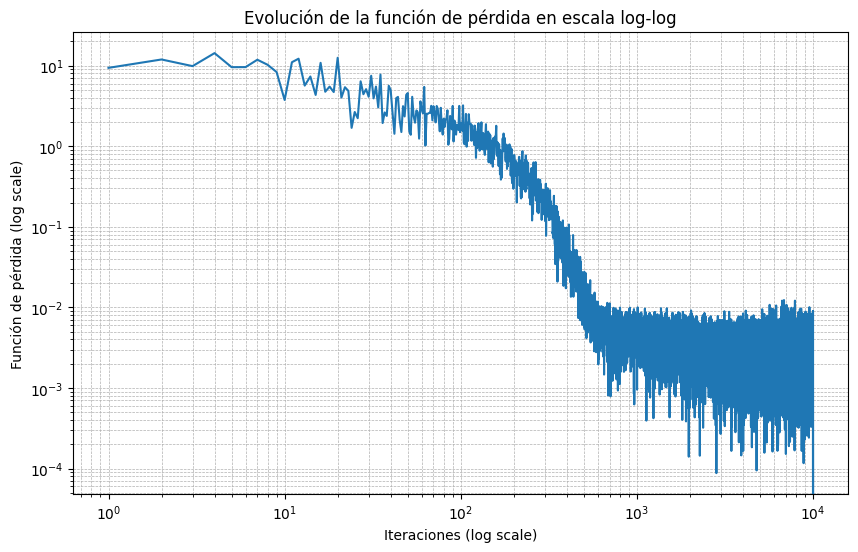

In [ ]:
perdida = valores_adam[1]

# Genera los índices para las iteraciones
iteraciones = np.arange(1, len(perdida) + 1)

# Crea el gráfico log-log
plt.figure(figsize=(10, 6))
plt.loglog(iteraciones, perdida)
plt.xlabel('Iteraciones (log scale)')
plt.ylabel('Función de pérdida (log scale)')
plt.title('Evolución de la función de pérdida en escala log-log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

2. Resultado de la red con los nuevos parametros $\theta$ despues de aplicar algoritmo Adam en contraste con los datos y la función sin ruido evaluada en puntos espaciados en [0,1] y en los puntos de entrenamiento.

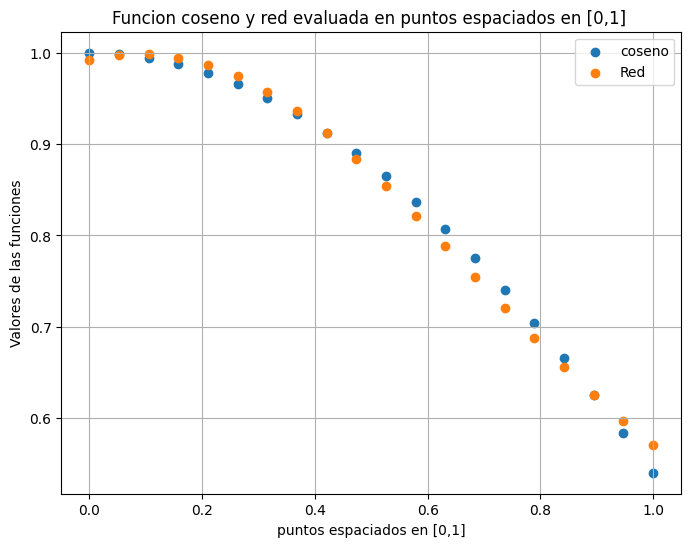

In [ ]:
# Para puntos espaciados en [0,1] :

np.random.seed(42)
x_prueba = np.linspace(0, 1, 20).reshape(1, 20)

plt.figure(figsize=(8,6))
plt.scatter(x_prueba[0], f_true(x_prueba)[0], label="coseno")
plt.scatter(x_prueba[0], net(valores_adam[0], x_prueba)[0], label="Red")
plt.xlabel("puntos espaciados en [0,1]")
plt.ylabel("Valores de las funciones")
plt.title("Funcion coseno y red evaluada en puntos espaciados en [0,1] ")
plt.legend()
plt.grid(True)
plt.show()

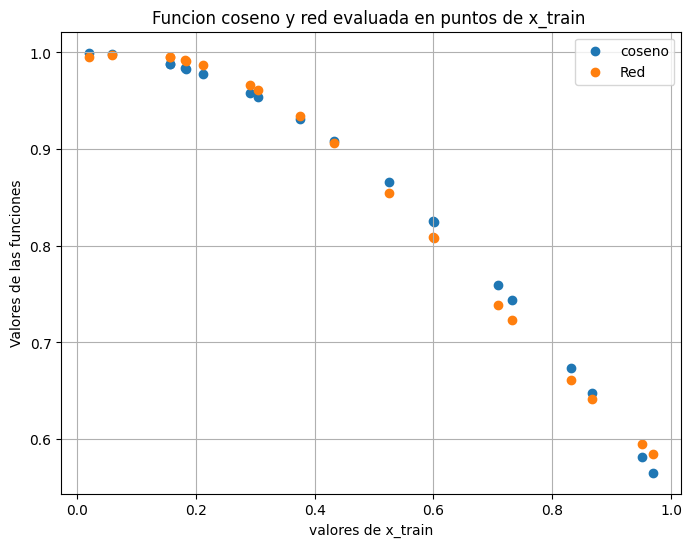

In [ ]:
# Para los puntos de entrenamiento, es decir, los x_train :

plt.figure(figsize=(8,6))
plt.scatter(x_train[0], f_true(x_train)[0], label="coseno")
plt.scatter(x_train[0], net(valores_adam[0], x_train)[0], label="Red")
plt.xlabel("valores de x_train")
plt.ylabel("Valores de las funciones")
plt.title("Funcion coseno y red evaluada en puntos de x_train ")
plt.legend()
plt.grid(True)
plt.show()

### **Ejercicio 2: Aproximación de esperanzas condicionales vía redes neuronales**

Sean $X$, $Y$ variables aleatorias y $f$ una función continua, luego es sabido de clases que el problema de encontrar una función que minimice el error cuadrático medio

$$  \min_{f} \mathbb{E} [(Y - f(X))^2] $$

Viene dado por

$$ f(x) = \mathbb{E} [Y \, | \, X = x] $$

El objetivo de este ejercicio es ver numéricamente como una red neuronal entrenada para minimizar el error cuadrático medio de una muestra de puntos $\{x_i, y_i \}$ tales que $f(x_i ) = y_i$, con $f$ desconocida, en realidad se aproxima a la esperanza condicional con $X$ e $Y$ tales que $x_i \sim X$, $y_i \sim Y$.

Para este ejercicio consideremos $X$ con ley $\text{Unif}(-1,1)$, la función que buscamos aproximar será

$$ f(x) = e^{-2 x^2}$$

Y la ley de $Y$ supongamos que es $f(X) \, + \, \text{N}(0, 0.1^2)$.

#### **Ejercicio 2.1: Generar datos de entrenamiento**

Samplee 100 puntos de la ley de $X$ dada antes y con ello obtenga 100 muestras aleatorias correspondientes de $Y$.

In [ ]:
#Nos generamos las variables aleatorias
np.random.seed(42)

X = np.random.uniform(-1, 1, 100)

#La función que queremos aproximar
def f(x):
    return np.exp(-2 * x**2)

#Establecemos la ley Y
w = np.random.normal(0, 0.1**2, 100)
Y = f(X) + w
Y

array([0.88255457, 0.19389264, 0.65105634, 0.90521087, 0.38586713,
       0.39158346, 0.2244279 , 0.33690787, 0.91337686, 0.7022448 ,
       0.16817585, 0.17421392, 0.40776964, 0.52095634, 0.44588098,
       0.45817971, 0.72894735, 0.99183233, 0.95970509, 0.69098221,
       0.90771849, 0.35616513, 0.7078249 , 0.86451806, 0.97052609,
       0.51752482, 0.48256311, 0.99035759, 0.93234532, 0.19692614,
       0.93048631, 0.42135357, 0.22272665, 0.19874661, 0.15729974,
       0.46699394, 0.73742629, 0.29854622, 0.7602854 , 0.97476831,
       0.31856466, 0.98812714, 0.1879427 , 0.26927454, 0.63573346,
       0.80043087, 0.76707937, 0.98276487, 0.98856522, 0.47369641,
       0.16143937, 0.54009233, 0.21424983, 0.2822995 , 0.91068395,
       0.24147735, 0.24739975, 0.48213077, 0.18198464, 0.79892748,
       0.8977816 , 0.65497696, 0.42937759, 0.83630024, 0.68346221,
       0.99859361, 0.34040297, 0.48347392, 0.23762527, 0.15791559,
       0.54033171, 0.47054984, 0.14663292, 0.4540423 , 0.71262

#### **Ejercicio 2.2: Cálculo de la esperanza condicional vía Montecarlo**

En este caso como es sabida la ley de $Y$ vía la función $f$ (en la realidad todo esto es desconocido) se puede calcular la esperanza condicional vía método de Montecarlo. Cree una función en Python que dado un $x \in [-1, 1]$ y una cantidad de muestras para la aproximación de Montecarlo, digamos $M$, calcule

$$ \mathbb{E} [Y \, | \, X = x] \approx \hat f = \frac{1}{M} \sum_{j=1}^M f(x) + w_j $$

Donde los $w_j$ vienen sampleados desde una $N(0, 0.1^2)$. Realice 3 gráficos de $\hat f$ en $[-1, 1]$ uno utilizando $M=10$, $M=100$, $M=1000$ ¿qué observa cuando $M$ aumenta?

In [ ]:
def montecarlo(x,muestras,M):
  # Utilizamos los mismos datos anteriores generados en w = np.random.normal(0, 0.1**2, 100)
  samples = f(x) + muestras[0:M]
  return np.mean(samples)

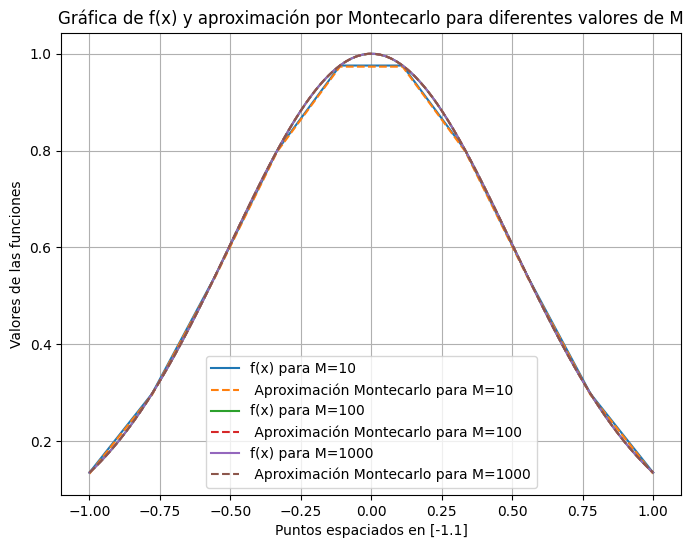

In [ ]:
# Valores de M
M_values = [10, 100, 1000]

plt.figure(figsize=(8, 6))

for M in M_values:
    x = np.linspace(-1, 1, M)
    # Calcular f(x)
    f_values = f(x)

    # Calcular montecarlo(x, M)
    montecarlo_values = np.array([montecarlo(xi, w, M) for xi in x])

    plt.plot(x, f_values, label=f'f(x) para M={M}')
    plt.plot(x, montecarlo_values, label=f' Aproximación Montecarlo para M={M}', linestyle='--')

plt.xlabel('Puntos espaciados en [-1.1]')
plt.ylabel('Valores de las funciones')
plt.legend()
plt.title('Gráfica de f(x) y aproximación por Montecarlo para diferentes valores de M')
plt.grid(True)

plt.show()

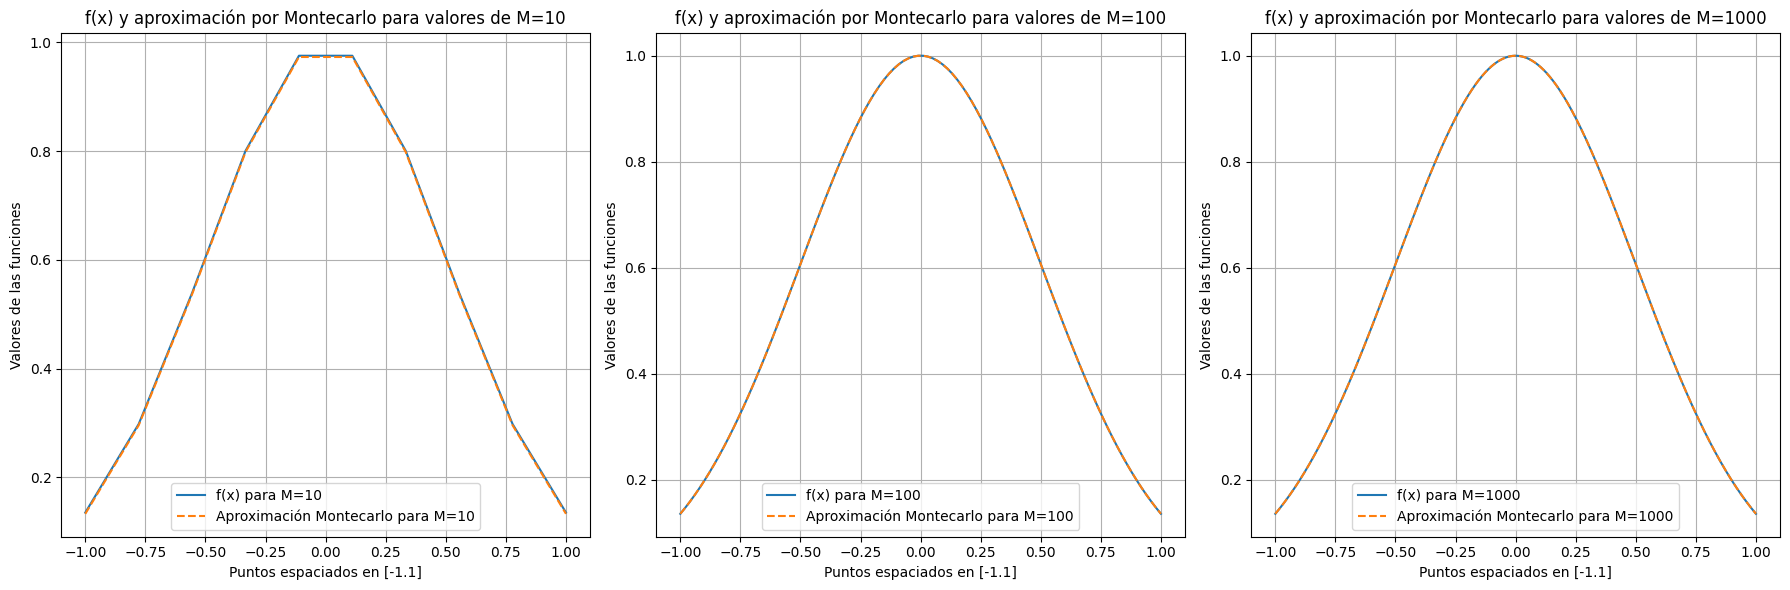

In [ ]:
# Valores de M
M_values = [10, 100, 1000]

# Crear subplots: 1 fila, 3 columnas
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Generar y plotear los datos para cada M
for i, M in enumerate(M_values):
    x = np.linspace(-1, 1, M)

    # Calcular f(x)
    f_values = f(x)

    # Calcular montecarlo(x, M)
    montecarlo_values = np.array([montecarlo(xi, w, M) for xi in x])

    # Plotear las líneas en el subplot correspondiente
    axs[i].plot(x, f_values, label=f'f(x) para M={M}')
    axs[i].plot(x, montecarlo_values, label=f'Aproximación Montecarlo para M={M}', linestyle='--')

    # Añadir etiquetas y título específico para cada subplot
    axs[i].set_xlabel('Puntos espaciados en [-1.1]')
    axs[i].set_ylabel('Valores de las funciones')
    axs[i].set_title('f(x) y aproximación por Montecarlo para valores de 'f'M={M}')
    axs[i].grid(True)
    axs[i].legend()

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### **Ejercicio 2.3: Observando la aproximación de una red neuronal**

Entrene una red neuronal de una sola capa oculta con pérdida cuadrática para que ajuste a los datos que usted generó en el ejercicio 2.1, puede utilizar la función de pérdida y el ancho que más le acomode (o que mejores resultados le entregue). Grafique la predicción de la red neuronal en $[-1, 1]$ y compare con el resultado del ejercicio 2.2.

*Indicación: Puede utilizar el código creado en el ejercicio 1, o bien, utilizar alguna librería como Pytorch, Tensorflow, etc.*

In [ ]:
xdim = 1   # Dimensión de input
Ndata = 20 # Cantidad de datos a samplear, ancho de la red
ydim = 1   # Dimensión de output

In [ ]:
# definamos parametros aleatorios, ded largo 3*Ndata + 1 como en P1 :

# RECORDAR QUE LOOS INTERNAMENTE OCUPA x_train,y_train POR LO QUE LAS VARIABLES SE DEBEN DEFINIR CON ESTOS NOMBRES

x_train = np.array([np.copy(X)])
y_train = np.array([np.copy(Y)])

In [ ]:
# Ejemplo :

y_train

array([[0.88255457, 0.19389264, 0.65105634, 0.90521087, 0.38586713,
        0.39158346, 0.2244279 , 0.33690787, 0.91337686, 0.7022448 ,
        0.16817585, 0.17421392, 0.40776964, 0.52095634, 0.44588098,
        0.45817971, 0.72894735, 0.99183233, 0.95970509, 0.69098221,
        0.90771849, 0.35616513, 0.7078249 , 0.86451806, 0.97052609,
        0.51752482, 0.48256311, 0.99035759, 0.93234532, 0.19692614,
        0.93048631, 0.42135357, 0.22272665, 0.19874661, 0.15729974,
        0.46699394, 0.73742629, 0.29854622, 0.7602854 , 0.97476831,
        0.31856466, 0.98812714, 0.1879427 , 0.26927454, 0.63573346,
        0.80043087, 0.76707937, 0.98276487, 0.98856522, 0.47369641,
        0.16143937, 0.54009233, 0.21424983, 0.2822995 , 0.91068395,
        0.24147735, 0.24739975, 0.48213077, 0.18198464, 0.79892748,
        0.8977816 , 0.65497696, 0.42937759, 0.83630024, 0.68346221,
        0.99859361, 0.34040297, 0.48347392, 0.23762527, 0.15791559,
        0.54033171, 0.47054984, 0.14663292, 0.45

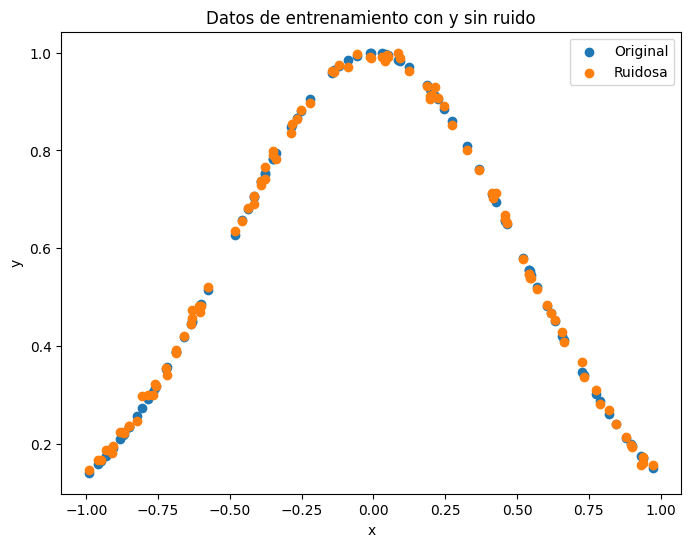

In [ ]:
#Esto es una matriz de 1X20

plt.figure(figsize=(8,6))
plt.scatter(x_train.flatten(), f(x_train).flatten(), label="Original")
plt.scatter(x_train.flatten(), y_train.flatten(), label="Ruidosa")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos de entrenamiento con y sin ruido")
plt.legend()
plt.show()

In [ ]:
# generamos parametros aleatorios
np.random.seed(42)

params_2 = np.random.randn(3*Ndata + 1)  # uniforme estándar
params_2

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
       -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124,
        0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
       -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016,
        0.32408397, -0.38508228, -0.676922  ,  0.61167629,  1.03099952,
        0.93128012, -0.83921752, -0.30921238,  0.33126343,  0.97554513,
       -0.47917424])

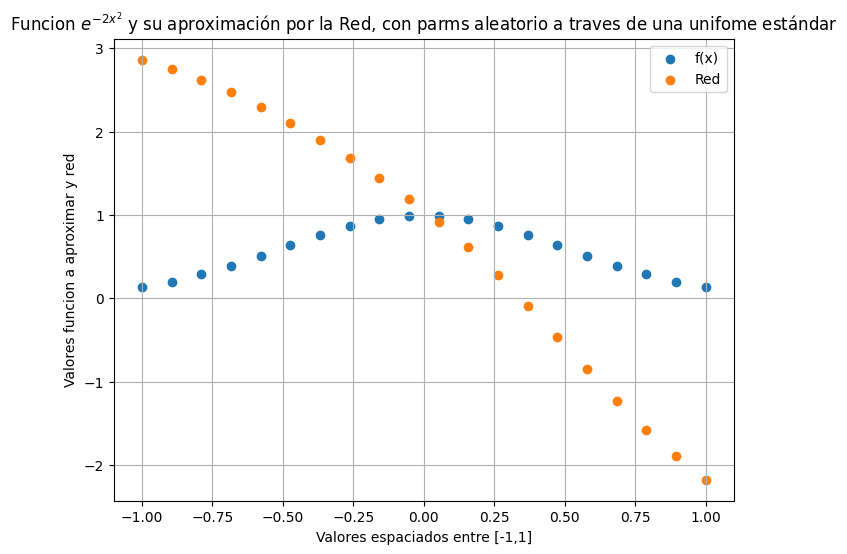

In [ ]:
# # Recordar que nuestro arreglo es net(params, x_train)[0] y no net(params,x_train)

np.random.seed(42)
x_prueba_2 = np.linspace(-1, 1, 20).reshape(1, 20)

plt.figure(figsize=(8,6))
plt.scatter(x_prueba_2[0], f(x_prueba_2)[0], label="f(x)")
plt.scatter(x_prueba_2[0], net(params_2, x_prueba_2)[0], label="Red")
plt.xlabel("Valores espaciados entre [-1,1]")
plt.ylabel("Valores funcion a aproximar y red")
plt.title("Funcion $e^{-2x^2}$ y su aproximación por la Red, con parms aleatorio a traves de una unifome estándar")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
valoresAdam = adam_optimize(params,alpha=0.001, beta1=0.9 , beta2=0.999, epsilon=10**-8,  iter=10_001,  Nbatches=5)

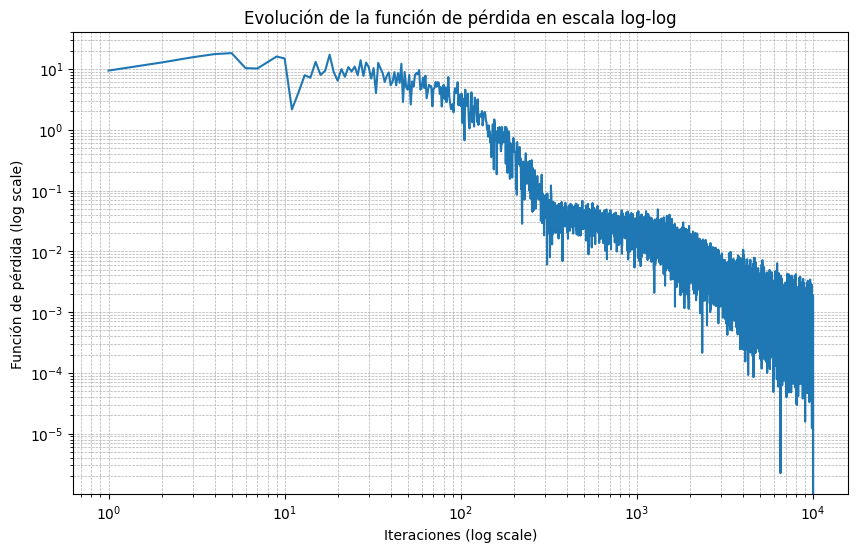

In [ ]:
perdida = valoresAdam[1]

# Genera los índices para las iteraciones
iteraciones = np.arange(1, len(perdida) + 1)

# Crea el gráfico log-log
plt.figure(figsize=(10, 6))
plt.loglog(iteraciones, perdida)
plt.xlabel('Iteraciones (log scale)')
plt.ylabel('Función de pérdida (log scale)')
plt.title('Evolución de la función de pérdida en escala log-log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

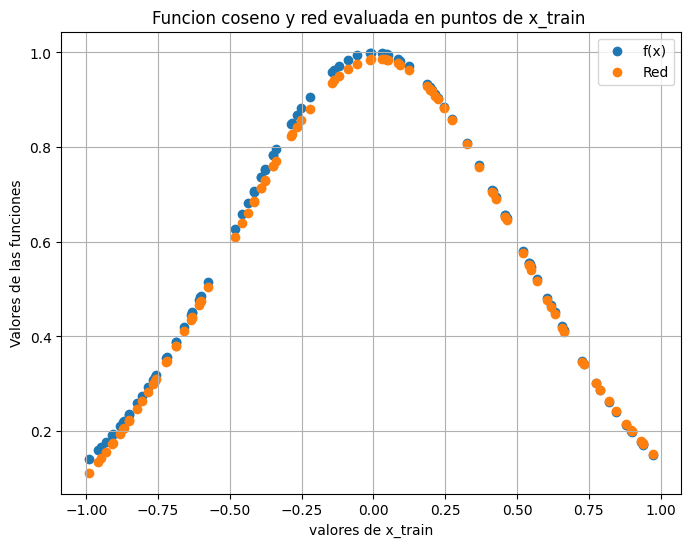

In [ ]:
# Para los puntos de entrenamiento, es decir, los x_train :

parametros = valoresAdam[0]

plt.figure(figsize=(8,6))
plt.scatter(x_train[0], f(x_train)[0], label="f(x)")
plt.scatter(x_train[0], net(parametros, x_train)[0], label="Red")
plt.xlabel("valores de x_train")
plt.ylabel("Valores de las funciones")
plt.title("Funcion coseno y red evaluada en puntos de x_train ")
plt.legend()
plt.grid(True)
plt.show()